In [6]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
def prep_data_prosup(df,window,interval=0,Normalize=False,rms=False,angle_thresh = 0.001,plot=False):
    angle_label = 'Pronation_Angle'
    emg_labels = ['EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6','EMG7', 'EMG8']
    emg_df = df[emg_labels]
    emg_df = pd.DataFrame(np.array(emg_df),columns=emg_labels)

    if(Normalize==True):
        emg_df = pd.DataFrame(norm(emg_df),columns=emg_labels)

    if(rms==True):
        emg_df = rms_df(emg_df,window)


    angle_div = int(len(emg_df)/1000)
    emg_array = np.array(emg_df)
    all_angle = np.array(df[angle_label])

    split_angles = np.array_split(all_angle,angle_div)

    labels = []
    for arr in split_angles:
        diff_arr = np.diff(arr)
        if abs(diff_arr.mean()) > angle_thresh:
            if diff_arr.mean()>0:
                labels = labels + [1]*arr.shape[0]
            else:
                labels = labels + [2]*arr.shape[0]
        else:
            labels = labels + [0]*arr.shape[0]

    segments = []
    X = []
    y = []
    i = 0
    counter = [0,0,0]
    while i < df.shape[0]-window:
        rmin = i
        rmax = i+window

        loc_arr = emg_array[rmin:rmax]
        X.append(loc_arr)
        max_label = np.bincount(np.array(labels[rmin:rmax])).argmax()

        if(max_label==0):
            y.append([1,0,0])
            segments.append([rmin,rmax,'1'])
            counter[0]=counter[0]+1
        elif(max_label==1):
            y.append([0,1,0])
            segments.append([rmin,rmax,'r'])
            counter[1]=counter[1]+1
        else:
            y.append([0,0,1])
            segments.append([rmin,rmax,'b'])
            counter[2]=counter[2]+1
        i = i + interval

    X = np.array(X)
    y = np.array(y)

    ## Plot Codes

    fig_size = (18,8)
    emg_df = pd.DataFrame(np.array(emg_df),columns=emg_labels)
    emg_df.plot(figsize=fig_size,title='EMG',legend=True)
    a = map_it(interval,(0,1000),(0,1))
    for x in segments:
        plt.axvspan(x[0],x[1],facecolor= x[2], alpha=a)
    clear_patch = mpatches.Patch(color='white', label='No Motion')
    blue_patch = mpatches.Patch(color='blue', label='Pronation')
    red_patch = mpatches.Patch(color='red', label='Supination')
    plt.legend(handles=[clear_patch,red_patch,blue_patch],loc=2)
    plt.show()

    plt.figure(figsize=fig_size)
    plt.plot(all_angle)
    plt.title(angle_label)
    plt.xlabel('t [2000hz]')
    plt.ylabel('Angle (deg)')
    plt.legend([angle_label],loc=2)
    for x in segments:
        plt.axvspan(x[0],x[1],facecolor= x[2], alpha=a)
    plt.show()
    for i in range(3):
        print(i,'->',counter[i]*100/X.shape[0],'%')
    return X, y

In [3]:
file = 'Subjects/Nikhil/computed_Bulb.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle']
df = pd.read_csv(file,index_col=0)[6500:85000]

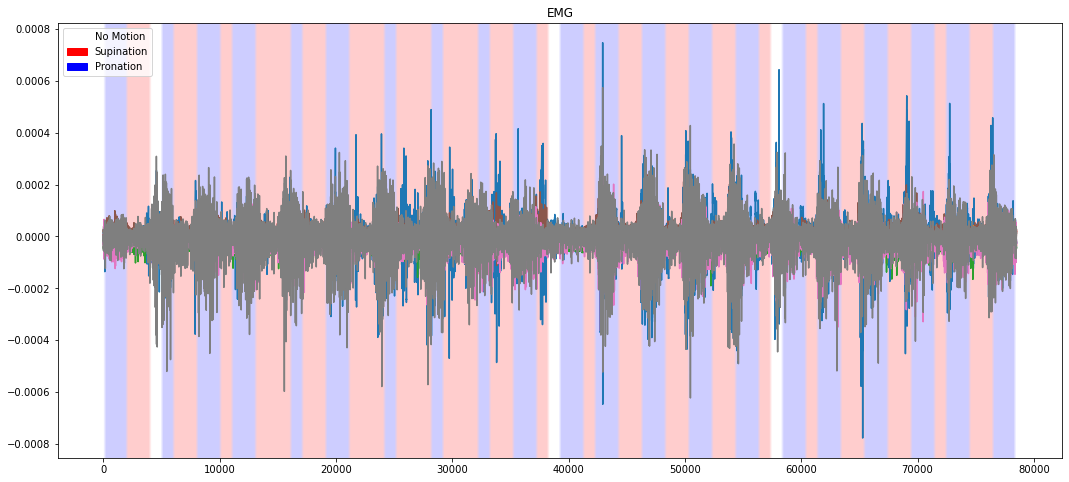

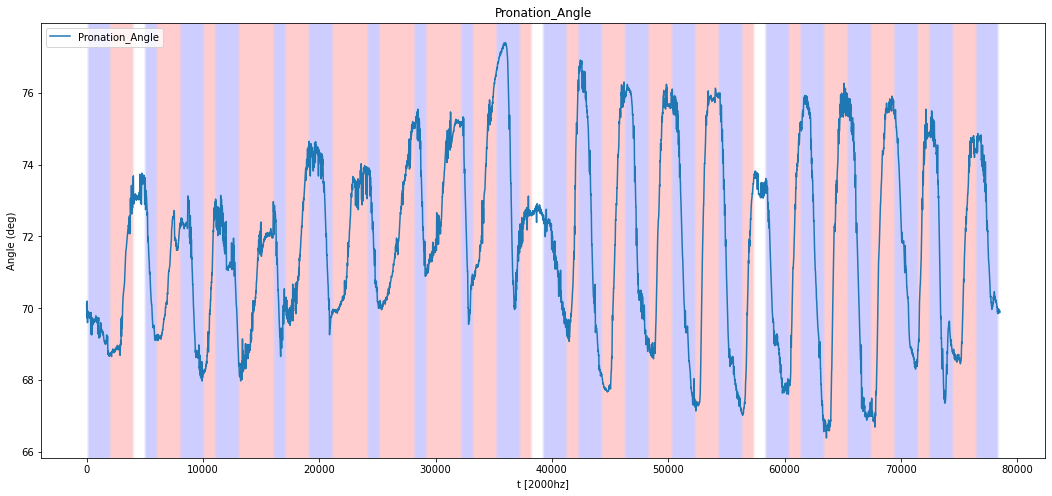

0 -> 3.8722044728434506 %
1 -> 48.894568690095845 %
2 -> 47.233226837060705 %


(15650, 250, 8)

In [5]:
X, y = prep_data_prosup(df,250,interval=5,Normalize=False,plot=True,angle_thresh=0.0002,rms=False)
X.shape

## Prep Data Prosup V1

In [ ]:
def prep_data_prosup(df,window,interval=0,Normalize=False,rms=False,angle_thresh = 0.001,plot=False):

    angle_label = 'Pronation_Angle'
    emg_labels = ['EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6',
           'EMG7', 'EMG8'] # , 'EMG9', 'EMG10', 'EMG11', 'EMG12'
    emg_df = df[emg_labels]
    emg_df = pd.DataFrame(np.array(emg_df),columns=emg_labels)

    if(Normalize==True):
        emg_df = pd.DataFrame(norm(emg_df),columns=emg_labels)
        
    if(rms==True):
        emg_df = rms_df(emg_df,window)
        
    emg_array = np.array(emg_df)
    all_angle = np.array(df[angle_label])
    segments = []
    X = []
    y = []
    i = 0
    counter = [0,0,0]
    while i < df.shape[0]-window:
        rmin = i
        rmax = i+window
        
        loc_arr = emg_array[rmin:rmax]
        X.append(loc_arr)
        angles = all_angle[rmin:rmax]
        
        diff = difference(angles).mean()
        
        if(abs(diff)<angle_thresh):
            y.append([1,0,0])
            segments.append([rmin,rmax,'1'])
            counter[0]=counter[0]+1
        elif(diff>0):
            y.append([0,1,0])
            segments.append([rmin,rmax,'r'])
            counter[1]=counter[1]+1
        else:
            y.append([0,0,1])
            segments.append([rmin,rmax,'b'])
            counter[2]=counter[2]+1
        i = i + interval
            
    X = np.array(X)
    y = np.array(y)

    
    ## Plot Codes
    if plot==True:
        fig_size = (18,8)
        emg_df = pd.DataFrame(np.array(emg_df),columns=emg_labels)
        emg_df.plot(figsize=fig_size,title='EMG',legend=True)
        a = map_it(interval,(0,1000),(0,1))
        for x in segments:
            plt.axvspan(x[0],x[1],facecolor= x[2], alpha=a)
        clear_patch = mpatches.Patch(color='white', label='No Motion')
        blue_patch = mpatches.Patch(color='blue', label='Pronation')
        red_patch = mpatches.Patch(color='red', label='Supination')
        plt.legend(handles=[clear_patch,red_patch,blue_patch],loc=2)
        plt.show()
        
        plt.figure(figsize=fig_size)
        plt.plot(all_angle)
        plt.title(angle_label)
        plt.xlabel('t [2000hz]')
        plt.ylabel('Angle (deg)')
        plt.legend([angle_label],loc=2)
        for x in segments:
            plt.axvspan(x[0],x[1],facecolor= x[2], alpha=a)
        plt.show()
        for i in range(3):
            print(i,'->',counter[i]*100/X.shape[0],'%')
    return X, y

## PROSUP Binary Version

In [ ]:
def prep_data_prosup_bin(df,window,interval=0,Normalize=False,rms=False,angle_thresh = 0.001,plot=False):
    angle_label = 'Pronation_Angle'
    emg_labels = ['EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6','EMG7', 'EMG8']
    emg_df = df[emg_labels]
    emg_df = pd.DataFrame(np.array(emg_df),columns=emg_labels)

    if(Normalize==True):
        emg_df = pd.DataFrame(norm(emg_df),columns=emg_labels)

    if(rms==True):
        emg_df = rms_df(emg_df,window)


    angle_div = int(len(emg_df)/500)
    emg_array = np.array(emg_df)
    all_angle = np.array(df[angle_label])

    split_angles = np.array_split(all_angle,angle_div)

    labels = []
    for arr in split_angles:
        diff_arr = np.diff(arr)
        if abs(diff_arr.mean()) > angle_thresh:
            if diff_arr.mean()>0:
                labels = labels + [1]*arr.shape[0]
            else:
                labels = labels + [2]*arr.shape[0]
        else:
            labels = labels + [0]*arr.shape[0]

    segments = []
    X = []
    y = []
    i = 0
    counter = [0,0,0]
    while i < df.shape[0]-window:
        rmin = i
        rmax = i+window

        loc_arr = emg_array[rmin:rmax]
#         X.append(loc_arr)
        max_label = np.bincount(np.array(labels[rmin:rmax])).argmax()

        if(max_label==0):
#             y.append([1,0,0])
            segments.append([rmin,rmax,'1'])
            counter[0]=counter[0]+1
        elif(max_label==1):
            X.append(loc_arr)
            y.append([1,0])
            segments.append([rmin,rmax,'r'])
            counter[1]=counter[1]+1
        else:
            X.append(loc_arr)
            y.append([0,1])
            segments.append([rmin,rmax,'b'])
            counter[2]=counter[2]+1
        i = i + interval
    X = np.array(X)
    y = np.array(y)

    ## Plot Codes
    if plot == True:
        fig_size = (18,8)
        emg_df = pd.DataFrame(np.array(emg_df),columns=emg_labels)
        emg_df.plot(figsize=fig_size,title='EMG',legend=True)
        a = map_it(interval,(0,1000),(0,1))
        for x in segments:
            plt.axvspan(x[0],x[1],facecolor= x[2], alpha=a)
        clear_patch = mpatches.Patch(color='white', label='No Motion')
        blue_patch = mpatches.Patch(color='blue', label='Pronation')
        red_patch = mpatches.Patch(color='red', label='Supination')
        plt.legend(handles=[clear_patch,red_patch,blue_patch],loc=2)
        plt.show()

        plt.figure(figsize=fig_size)
        plt.plot(all_angle)
        plt.title(angle_label)
        plt.xlabel('t [2000hz]')
        plt.ylabel('Angle (deg)')
        plt.legend([angle_label],loc=2)
        for x in segments:
            plt.axvspan(x[0],x[1],facecolor= x[2], alpha=a)
        plt.show()
        for i in range(3):
            print(i,'->',counter[i]*100/X.shape[0],'%')
    return X, y

## DF Oriented Normalization

In [ ]:
def norm(df):
    if len(df.shape)==1:
        df = np.array(df)
        df  = df.reshape(-1,1)
    scaler = StandardScaler(with_mean=True,
                            with_std=True,
                            copy=False).fit(df)
    # dump(scaler, open('standard_scaler_filtered_master.pkl', 'wb'))
    # scaler = load(open('standard_scaler_master.pkl', 'rb')) #'standard_scaler_filtered_master.pkl'
    df = scaler.transform(df)

    mx_scaler = MinMaxScaler(feature_range=(0,1))
    mx_scaler.fit(df)
    # dump(mx_scaler, open('minmax_scaler_filtered_master.pkl', 'wb'))
    # mx_scaler = load(open('mx_standard_scaler_master.pkl', 'rb')) #'standard_scaler_master.pkl'
    df = mx_scaler.transform(df)

    return df